processing..
War 5254 started at 1680879600 and ended at 1680958985.
The Power Rangers had a score of 7286.
Drunk Squad had a score of 982.
The winner was faction 44762.
winner faction -> https://www.torn.com/factions.php?step=profile&ID=44762#/
processing...
Total hits made: 1303
Total hits received: 272


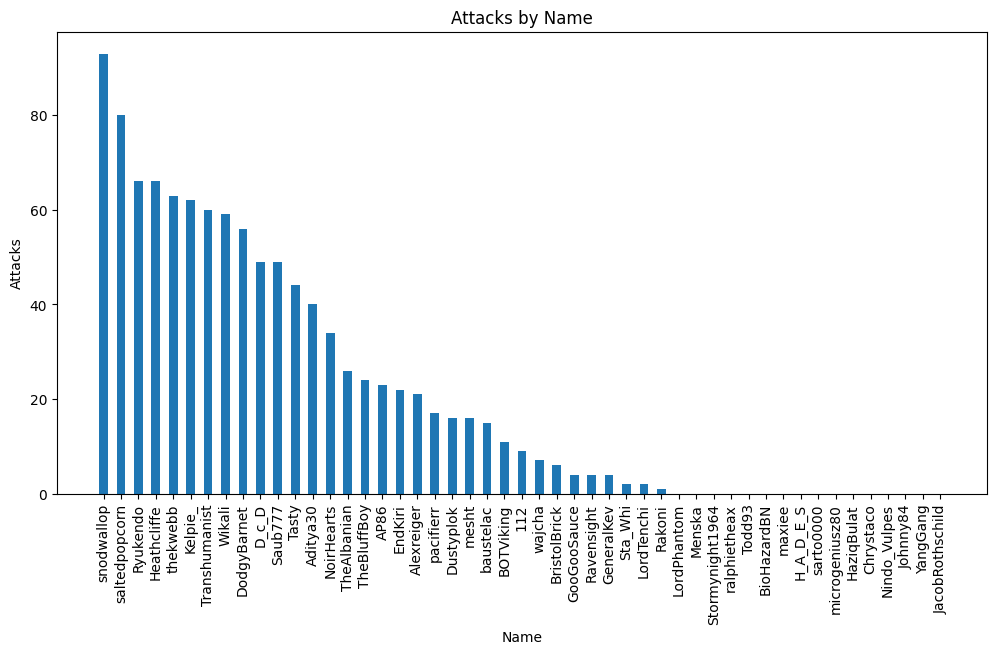

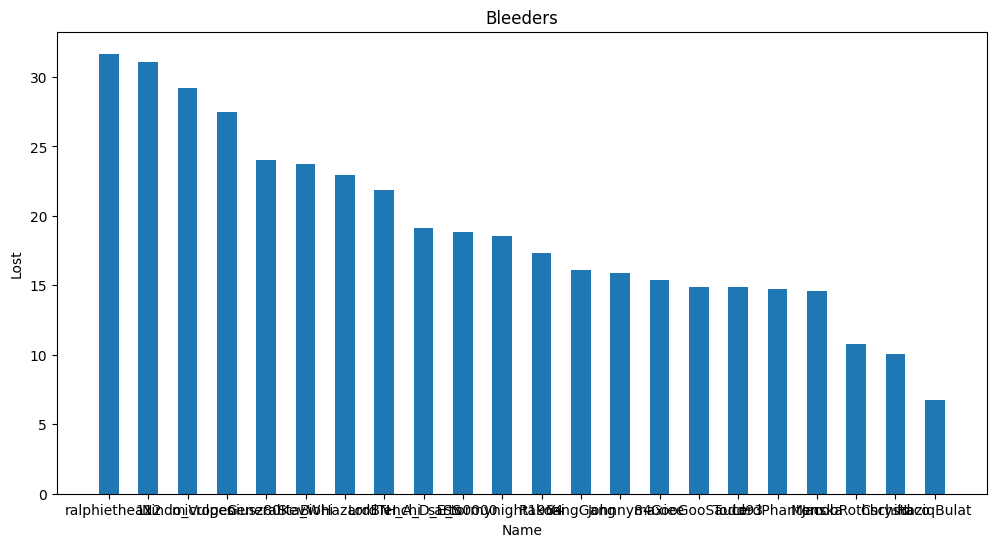

In [15]:
import requests
import csv
from datetime import timezone, datetime
import time
import json
import pandas as pd
import matplotlib.pyplot as plt


# constant definitions
FILE_NAME = "output.csv"
LOST = 'lost'
DEFENDER_NAME = 'defender_name'
DEFENDER_ID = 'defender_id'
GAINED = 'gained'
RESPECT = 'respect'
CHAIN_BONUS = 'chain_bonus'
MODIFIERS = 'modifiers'
ATTACKER_NAME = 'attacker_name'
ATTACKER_ID = 'attacker_id'
DEFENDER_FACTION = 'defender_faction'
DEFENDER_FACTION_NAME = 'defender_factionname'
ATTACKER_FACTION_NAME = 'attacker_factionname'
RANKED_WAR = 'ranked_war'
TIMESTAMP_STARTED = 'timestamp_started'
ATTACKS_KEY = 'attacks'
OUTSIDE_ATTACKS_KEY = 'outside_attacks'
NAME_KEY= 'name'
RESPECT_GAINED_KEY="gained"
RESPECT_LOST_KEY="lost"

HEADER = ['id', 'name', 'attacks', 'outside_attacks', 'gained', 'lost']

extra_calls = [',applications', ',armor', ',armorynews', ',attacknews',
               ',basic', ',boosters', ',cesium', ',chain', ',chainreport',
               ',chains', ',contributors', ',crimenews', ',crimes',
               ',currency', ',donations', ',drugs', ',fundsnews',
               ',mainnews', ',medical', ',membershipnews', ',positions',
               ',reports', ',revives', ',revivesfull', ',stats', ',temporary',
               ',territory', ',territorynews', ',timestamp', ',upgrades', ',weapons '
               ]


def losing_member_record(attack_id, attacks_list):
    return {
        'name': attacks_list[attack_id][DEFENDER_NAME],
        'attacks': 0,
        'outside_attacks': 0,
        'gained': 0,
        'lost': 0
    }


def winning_member_record(attack_id, attacks_list):
    return {
        'name': attacks_list[attack_id][ATTACKER_NAME],
        'attacks': 0,
        'outside_attacks': 0,
        'gained': 0,
        'lost': 0
    }


def is_ranked_war_attack(attack_id, attacks_list):
    return attacks_list[attack_id][RANKED_WAR] == 1


def get_timestamp(start_day, start_hour, start_min, month, year):
    return int(datetime(year, month, start_day, start_hour, start_min, tzinfo=timezone.utc).timestamp())


def process_attacks(end_stamp, enemy_faction_name, hero_faction_name, start_stamp, api_key):
    next_call_stamp = start_stamp
    scores = {}
    processed_attack_records = []
    count = 0
    outgoing = 0
    incoming = 0
    print('processing...')

    while next_call_stamp <= end_stamp:
        count += 1
        time.sleep(2)
        # print(f'{next_call_stamp}')
        request = requests.get(
            f'https://api.torn.com/faction/?selections=attacks'
            f'{extra_calls[count % len(extra_calls)]}&from={next_call_stamp}&key={api_key}')

        # Open the file for reading
        # with open("test.json", "r") as file:
        #     # Load JSON data from the file
        #     response_body = {json.load(file)}

        response_body = request.json()
        # Open the file for writing
        with open("test.json", "w") as file:
            # Write JSON data to the file
            json.dump(response_body, file)


        # attack object found
        try:
            attacks_list = response_body[ATTACKS_KEY]

            for attack_id in attacks_list:
                # update timestamp to set the next 'from' field in the API call
                attack_obj = attacks_list[attack_id]
                if attack_obj[TIMESTAMP_STARTED] > next_call_stamp:
                    next_call_stamp = attack_obj[TIMESTAMP_STARTED] - 1

                if attack_id not in processed_attack_records:
                    processed_attack_records.append(attack_id)
                    is_rw_attack = is_ranked_war_attack(attack_id, attacks_list)

                    # outside hits
                    if attack_obj[ATTACKER_FACTION_NAME] == hero_faction_name and attack_obj[DEFENDER_FACTION_NAME] != enemy_faction_name:
                        # create a new record if not encountered before
                        if attack_obj[ATTACKER_ID] not in scores.keys():
                            scores[attack_obj[ATTACKER_ID]] = winning_member_record(attack_id, attacks_list)
                        # update existing record
                        scores[attack_obj[ATTACKER_ID]][OUTSIDE_ATTACKS_KEY] = scores[attack_obj[ATTACKER_ID]][OUTSIDE_ATTACKS_KEY] + 1
                        outgoing = outgoing + 1

                    # attack is against enemy faction and made by hero faction
                    if attack_obj[DEFENDER_FACTION_NAME] == enemy_faction_name and is_rw_attack:
                        # create a new record if not encountered before
                        if attack_obj[ATTACKER_ID] not in scores.keys():
                            scores[attack_obj[ATTACKER_ID]] = winning_member_record(attack_id, attacks_list)
                        # update existing record
                        if attack_obj[MODIFIERS][CHAIN_BONUS] < 10:
                            scores[attack_obj[ATTACKER_ID]][GAINED] = scores[attack_obj[ATTACKER_ID]][GAINED] + attack_obj[RESPECT]
                            scores[attack_obj[ATTACKER_ID]][ATTACKS_KEY] = scores[attack_obj[ATTACKER_ID]][ATTACKS_KEY] + 1
                        outgoing = outgoing + 1

                    # attack is against hero faction and made by target enemy faction
                    if attack_obj[DEFENDER_FACTION_NAME] == hero_faction_name and is_rw_attack:
                        # create a new record if not encountered before
                        if attack_obj[DEFENDER_ID] not in scores.keys():
                            scores[attack_obj[DEFENDER_ID]] = losing_member_record(attack_id, attacks_list)
                        # update existing record
                        if attack_obj[MODIFIERS][CHAIN_BONUS] < 10:
                            scores[attack_obj[DEFENDER_ID]][LOST] = scores[attack_obj[DEFENDER_ID]][LOST] + attack_obj[RESPECT]
                        incoming = incoming + 1
        except KeyError:
            print("No more attacks left to process")
            break

    print(f'Total hits made: {outgoing}')
    print(f'Total hits received: {incoming}')

    # print(scores)

    with open(FILE_NAME, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(HEADER)
        for member in scores:
            writer.writerow([member, 
                            scores[member][NAME_KEY],
                            scores[member][ATTACKS_KEY],
                            scores[member][OUTSIDE_ATTACKS_KEY],
                            scores[member][RESPECT_GAINED_KEY],
                            scores[member][RESPECT_LOST_KEY]])



def find_start_end(hero_faction_name, enemy_faction_name, api_key):
    print("processing..")
    # Make the API call and get the response
    response = requests.get(f"https://api.torn.com/torn/?selections=rankedwars&key={api_key}")

    # Load the response JSON into a Python dictionary
    data = json.loads(response.text)

    # Iterate through each ranked war
    for war_id, war_info in data['rankedwars'].items():
        # Initialize variables to store faction 1 and faction 2 info
        hero_faction_info = None
        enemy_faction_info = None
        
        # Iterate through each faction in the war
        for faction_id, faction_info in war_info['factions'].items():
            # If the faction name matches the first one we're interested in
            if faction_info['name'] == hero_faction_name:
                hero_faction_info = faction_info
            # If the faction name matches the second one we're interested in
            elif faction_info['name'] == enemy_faction_name:
                enemy_faction_info = faction_info
        
        # If we found both factions in this war and no other factions
        if hero_faction_info is not None and enemy_faction_info is not None and len(war_info['factions']) == 2:
            # Get the war start and end times, and winner ID
            war_start = war_info['war']['start']
            war_end = war_info['war']['end']
            winner_id = war_info['war']['winner']
            # Print the results
            print(f"War {war_id} started at {war_start} and ended at {war_end}.")
            print(f"{hero_faction_name} had a score of {hero_faction_info['score']}.")
            print(f"{enemy_faction_name} had a score of {enemy_faction_info['score']}.")
            print(f"The winner was faction {winner_id}.")
            return {war_start, war_end, f"https://www.torn.com/factions.php?step=profile&ID={winner_id}#/"}

def generate_report(hero_faction_name, enemy_faction_name, api_key):
    start_stamp, end_stamp, winner_fac_link = find_start_end(hero_faction_name,enemy_faction_name, api_key)
    print(f"winner faction -> {winner_fac_link}")
    process_attacks(end_stamp, enemy_faction_name, hero_faction_name, start_stamp, api_key)

def visualize_report():
    # Create a dataframe from the data
    df = pd.read_csv('output.csv')

    # Sort the dataframe by the "attacks" column
    df = df.sort_values(by='attacks', ascending=False)
    plt.figure(figsize=(12,6))

    # Create a bar chart of the "attacks" column
    plt.bar(df['name'], df['attacks'], width=0.5)
    plt.xticks(rotation=90)
    plt.xlabel('Name')
    plt.ylabel('Attacks')
    plt.title('Attacks by Name')
    plt.show()

    # Get the bleeders
    bleeders = df[df['lost'] > df['gained']].sort_values(by='lost', ascending=False)

    # Get names and lost values
    names = bleeders['name']
    lost = bleeders['lost']

    # Create the bar graph
    plt.figure(figsize=(12, 6))
    plt.bar(names, lost, width=0.5)
    plt.xticks(rotation=90)
    plt.xlabel('Name')
    plt.ylabel('Lost')
    plt.title('Bleeders')
    plt.show()


generate_report(hero_faction_name="The Power Rangers", enemy_faction_name="Drunk Squad", api_key="08plK5nye2UYJLSi")
visualize_report()
